In [1]:
from model import Model
import numpy as np
import argparse
from datetime import datetime
import os
import sys
import time
from torch import nn
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset
import numpy as np
from model import Model
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
import torch.utils.data

# device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Model(num_classes=1, num_features=128,num_instances=4)
# model.to(device)
# model

Duplicate key in file PosixPath('/home/ubuntu/.local/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 769 ('font.family\t\t\t : sans-serif')
Duplicate key in file PosixPath('/home/ubuntu/.local/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 770 ('font.sans-serif\t\t : SimHei')
Duplicate key in file PosixPath('/home/ubuntu/.local/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 771 ('axes.unicode_minus   : False                                 # animation in HTML (i.e. IPython notebook)')


In [2]:
training_data = datasets.MNIST(
    root="../data",
    train=True,
    download=False,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="../data",
    train=False,
    download=False,
    transform=ToTensor()
)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


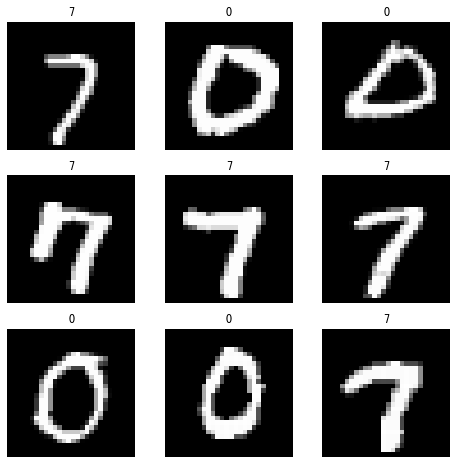

In [3]:
training_data_filter = [(i,j) for (i,j) in training_data if j==0 or j==7]
test_data_filter = [(i,j) for (i,j) in test_data if j==0 or j==7]
labels_map = np.arange(0,10,1)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data_filter), size=(1,)).item()
    img, label = training_data_filter[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
from typing import List, Dict, Tuple
import copy
def data_generation(instance_index_label: List[Tuple]) -> List[Dict]:
    """
    bags: {key1: [ind1, ind2, ind3],
           key2: [ind1, ind2, ind3, ind4, ind5],
           ... }
    bag_lbls:
        {key1: 0,
         key2: 1,
         ... }
    """
    bag_size = np.ones(len(instance_index_label)//20,dtype = np.int)+99
    data_cp = copy.copy(instance_index_label)
    np.random.shuffle(data_cp)
    bags = {}
    bags_per_instance_labels = {}
    bags_labels = {}
    for bag_ind, size in enumerate(bag_size):
        bags[bag_ind] = []
        bags_per_instance_labels[bag_ind] = []
        p = np.random.randint(0,101)

        try:
            for _ in range(size):
                r = np.random.randint(0,len(instance_index_label))
                inst_ind, lbl = data_cp[r][0],data_cp[r][1]
                while p>0 and lbl ==7:
                    r = np.random.randint(0,len(instance_index_label))
                    inst_ind, lbl = data_cp[r][0],data_cp[r][1]
                while p==0 and lbl ==0:
                    r = np.random.randint(0,len(instance_index_label))
                    inst_ind, lbl = data_cp[r][0],data_cp[r][1]
                if p>0 and lbl==0:
                    p-=1    
                bags[bag_ind].append(inst_ind)
                # simplfy, just use a temporary variable instead of bags_per_instance_labels
                bags_per_instance_labels[bag_ind].append(lbl)
            bags_labels[bag_ind] = bag_label_from_instance_labels(bags_per_instance_labels[bag_ind])
        except:
            break
    return bags, bags_labels

def bag_label_from_instance_labels(instance_labels):
    return int(sum(((x==0) for x in instance_labels)))/100
from torch.utils.data import Dataset
class Transform_data(Dataset):
    """
    We want to 1. pad tensor 2. transform the data to the size that fits in the input size.
    
    """

    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = data
        
    def __getitem__(self, index):
        tensor = self.data[index][0]
        if self.transform is not None:
            tensor = self.transform(tensor)
        return (tensor, self.data[index][1])

    def __len__(self):
        return len(self.data)

def pad_tensor(data:list, max_number_instance) -> list:
    """
    Since our bag has different sizes, we need to pad each tensor to have the same shape (max: 7).
    We will look through each one instance and look at the shape of the tensor, and then we will pad 7-n 
    to the existing tensor where n is the number of instances in the bag.
    The function will return a padded data set."""
    new_data = []
    for bag_index in range(len(data)):
        tensor_size = len(data[bag_index][0])
        pad_size = max_number_instance - tensor_size
        p2d = (0,0, 0, pad_size)
        padded = nn.functional.pad(data[bag_index][0], p2d, 'constant', 0)
        new_data.append((torch.reshape(padded,(-1,28,28)), data[bag_index][1]))
    return new_data

def get_data_loaders(train_data, test_data, train_batch_size=64, val_batch_size=64):
    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader


def construct_data(instance_index_label,data):
    bag_indices, bag_labels = data_generation(instance_index_label)
    bag_features = {kk: torch.Tensor([data[i][0].numpy() for i in inds]) for kk, inds in bag_indices.items()}
    train_data = [(bag_features[i],bag_labels[i]) for i in range(len(bag_features)-1)]
    max_number_instance = 100
    padded_data = pad_tensor(train_data, max_number_instance)
    return padded_data

In [5]:
instance_index_label = [(i , training_data_filter[i][1]) for i in range(len(training_data_filter))]
instance_index_label_test = [(i , test_data_filter[i][1]) for i in range(len(test_data_filter))]
padded_train = construct_data(instance_index_label,training_data_filter)
padded_test = construct_data(instance_index_label_test,test_data_filter)

In [21]:
model = torch.load("Q2.pt")

In [22]:
ys = [b for (_,b) in padded_test]
y_s = [model(a.reshape([-1,1,28,28])) for (a,_) in padded_test]
# # a,b = padded_test[2]
# # a = a.reshape([-1,1,28,28])
# r = np.random.randint(0,101)
# r

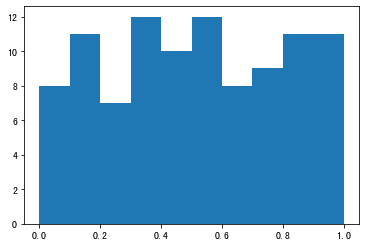

In [23]:
plt.hist(np.array(ys,dtype=np.float))
y_s = np.array(y_s,dtype=np.float)
# ys

(0.0, 1.0)

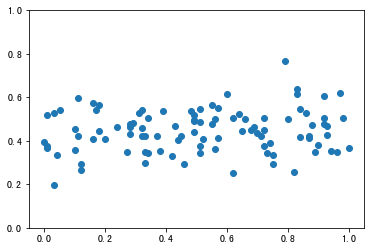

In [24]:
plt.scatter(ys,y_s)
# plt.xlim([0,1])
plt.ylim([0,1])

In [ ]:
# plt.scatter(ys,y_s.detach())
a,b = padded_test[12]
# model(a.reshape([-1,1,28,28])),b

In [ ]:
# a = a.reshape([28*10,28*10])
b = a[0:4].flatten()
plt.imshow(b.view([56,-1]))
a.shape

In [ ]:
b =  b.view([28*2,-1])
# plt.imshow(b.view([28,-1]))
b.shape
plt.imshow(b[0:56,0:56])

In [ ]:

def make_grid(data, size=(4,4)):
    rows, columns = size[0], size[1]
    data = np.array(data)
 
    # if (data<=1).all():
    #     data = (data*255).astype(np.uint8)
        
    data_row, data_columns = [], []
    for row in range(rows):
        data_columns.clear()
        for column in range(columns):
            data_columns.append(data[row*columns+column])
        data_row.append(np.hstack(copy.deepcopy(data_columns)))
 
    data = np.vstack(data_row)
    return data


In [ ]:
plt.imshow(make_grid(a,(10,10)))
b = make_grid(a,(10,10))
# b[]
b[10]
plt.imshow(b.reshape([28*5,-1]))
# c = torch.tensor([1,2,3,4,5,6])
# c.reshape([-1,2])
# a = a.reshape([-1,1,28,28])
# c = a.reshape ([-1,100,28*28])
# c.shape
# plt.imshow(c[0][0].reshape([28,28]))